# Experiments

In [1]:
!nvidia-smi

Sat Mar 23 00:20:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.09                 Driver Version: 546.09       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   46C    P5              21W / 320W |   1762MiB / 16376MiB |     30%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# required imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image

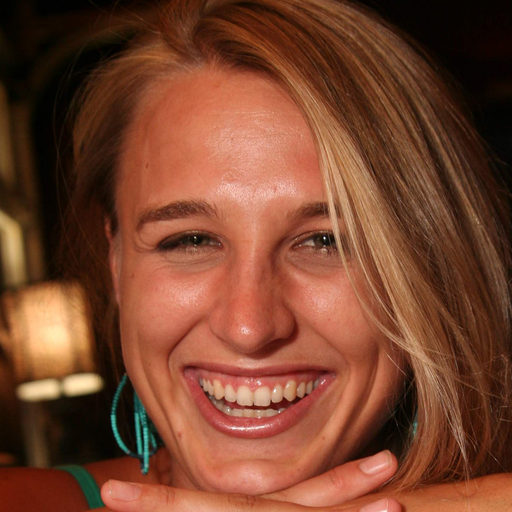

In [3]:
# read the image
image = Image.open('test.png')
display(image)

In [6]:
# convert the image to torch tensor
image_tensor = torch.tensor(np.array(image))
image_tensor = image_tensor.permute(2, 0, 1)
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.float()
image_tensor /= 255.0

print(image_tensor)

tensor([[[[0.0118, 0.0078, 0.0000,  ..., 0.0314, 0.0235, 0.0196],
          [0.0078, 0.0039, 0.0078,  ..., 0.0314, 0.0235, 0.0196],
          [0.0118, 0.0000, 0.0039,  ..., 0.0314, 0.0235, 0.0196],
          ...,
          [0.4392, 0.4314, 0.4392,  ..., 0.8235, 0.8314, 0.8078],
          [0.4353, 0.4275, 0.4353,  ..., 0.8157, 0.8275, 0.8235],
          [0.4353, 0.4314, 0.4275,  ..., 0.8196, 0.8235, 0.8235]],

         [[0.0118, 0.0078, 0.0000,  ..., 0.0118, 0.0157, 0.0157],
          [0.0078, 0.0039, 0.0078,  ..., 0.0118, 0.0157, 0.0157],
          [0.0118, 0.0000, 0.0039,  ..., 0.0118, 0.0157, 0.0157],
          ...,
          [0.1059, 0.0980, 0.1059,  ..., 0.5059, 0.5137, 0.4902],
          [0.1020, 0.0941, 0.1020,  ..., 0.4980, 0.5098, 0.5059],
          [0.1020, 0.0980, 0.0941,  ..., 0.5020, 0.5059, 0.5059]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0039,  ..., 0